# Machine learning-based framework for prospectivity mapping of critical minerals

### Ehsan Farahbakhsh, R. Dietmar M&uuml;ller

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

This notebook enables the user to create a prospectivity map of critical minerals in New South Wales, particularly the Lachlan Orogen. It comprises two main sections; in the first section, the available datasets are visualised, and in the second section, machine learning algorithms are applied to create a prospectivity map.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cmcrameri.cm as cmc
import contextily as cx
import geopandas as gpd
from ipywidgets import interact
from lib import *
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from numpy import genfromtxt
from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
import pickle
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from shapely.strtree import STRtree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

### Mineral Occurrences

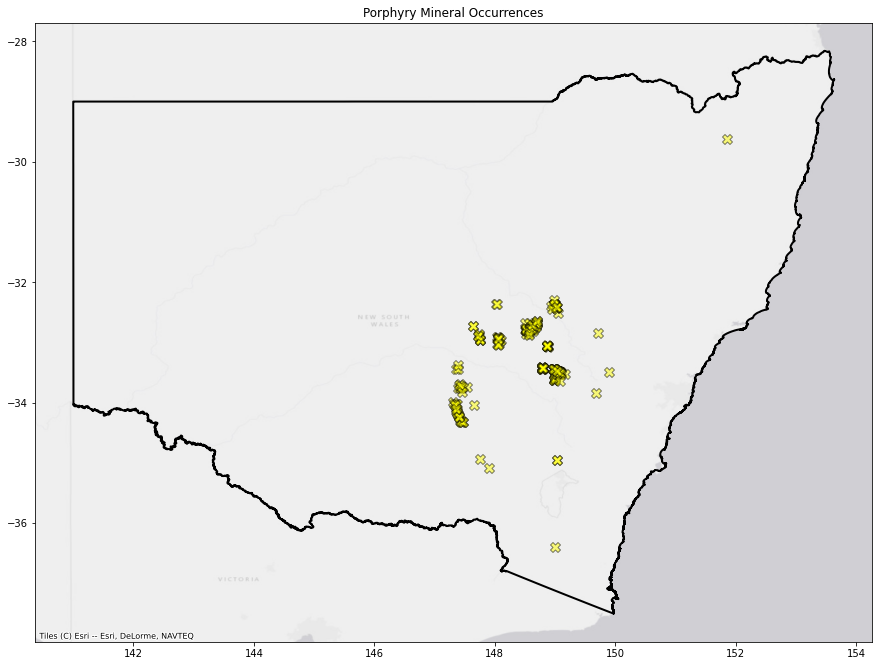

In [2]:
min_occ = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry.shp')
nsw_bndy = gpd.read_file('./Datasets/Frames/NSW_Boundary/NSW_STATE_POLYGON_shp_GDA94_NoIsland_ACT.shp')
# frame_target = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')
frame_target = gpd.read_file('./Datasets/Frames/NSW_Boundary/NSW_STATE_POLYGON_shp_GDA94_NoIsland_ACT.shp')

bounds = nsw_bndy.bounds
extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

bounds_target = frame_target.bounds
extent_target = [bounds_target.loc[0]['minx'], bounds_target.loc[0]['maxx'], bounds_target.loc[0]['miny'], bounds_target.loc[0]['maxy']]

fig, ax = plt.subplots(figsize=(15, 15))
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Porphyry Mineral Occurrences')
plt.show()

### Vector Data Layers

#### Intrusion Boundaries

In [3]:
intrusion_bndy_files = [
    './Datasets/Geology/Polylines/IntrusionsBndys_FaultedBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_IntrusiveBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_UnconformableBndys.shp'
]

@interact(dataset=intrusion_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
#     frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Intrusion Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/IntrusionsBndys_F…

#### Metamorphic Boundaries

In [4]:
metamorphic_bndy_files = [
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Faults.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_MetamorphicBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Unconformities.shp'
]

@interact(dataset=metamorphic_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
#     frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Metamorphic Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/MetamorphicBounda…

#### Metamorphic Isograds

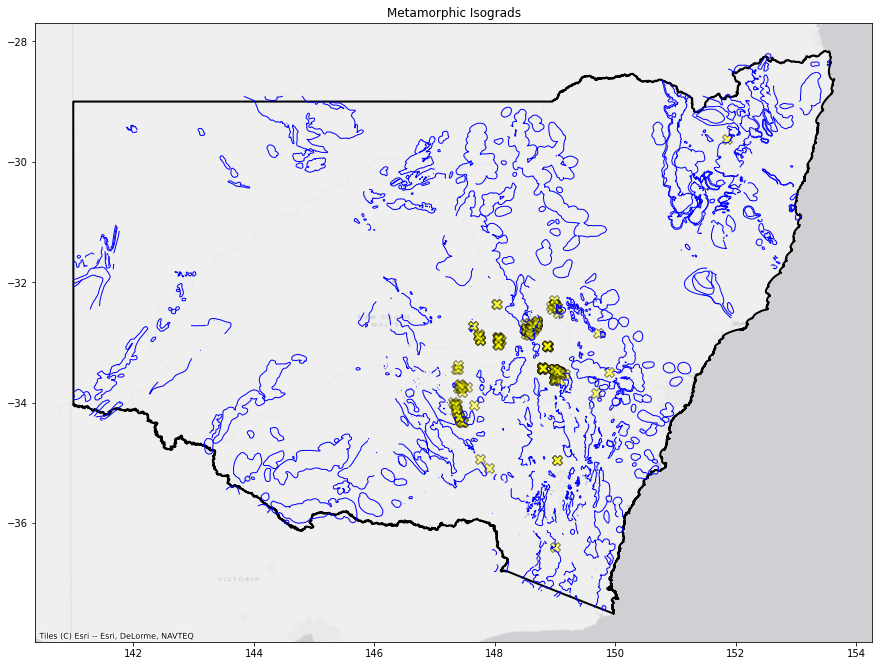

In [5]:
metamorphic_iso_file = './Datasets/Geology/Polylines/MetamorphicIsograds.shp'
metamorphic_iso = gpd.read_file(metamorphic_iso_file)

fig, ax = plt.subplots(figsize=(15, 15))
metamorphic_iso.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Metamorphic Isograds')
plt.show()

#### Rock Units, Boundaries, and Fault Layers

In [6]:
bndy_files = [
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Faulted boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Geological boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Intrusive boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Unconformable boundary.shp'
]

@interact(dataset=bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
#     frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/RockUnitBndyFault…

#### Cluster Boundaries of Shear Wave Velocity

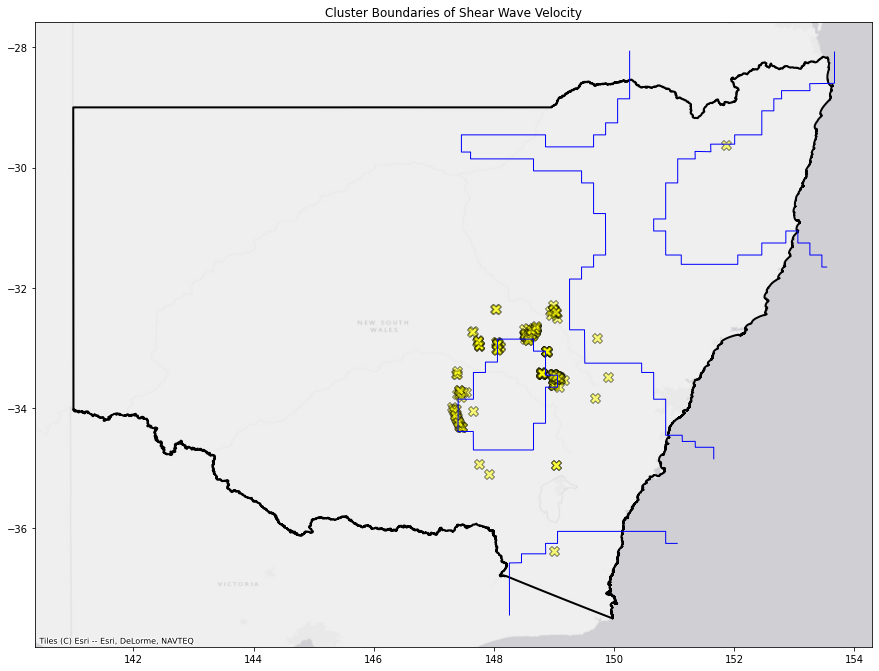

In [7]:
vs_cluster_file = './Datasets/Seismic/vs_cluster_boundaries.shp'
vs_cluster = gpd.read_file(vs_cluster_file)

fig, ax = plt.subplots(figsize=(15, 15))
vs_cluster.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Cluster Boundaries of Shear Wave Velocity')
plt.show()

#### Intrusions

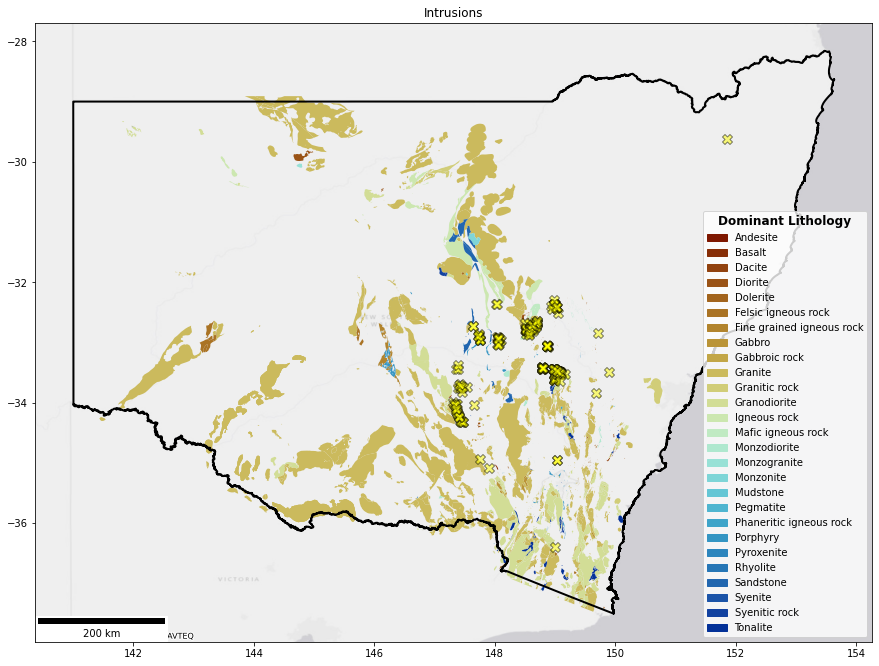

In [8]:
# Load the shapefile
intrusions_file = './Datasets/Geology/Polygons/Intrusions_Tabberabberan.shp'
intrusions = gpd.read_file(intrusions_file)

# Ensure there is a column to differentiate the geological units, for example 'unit'
# If 'unit' does not exist, replace 'unit' with the appropriate column name
intrusions_units = sorted(intrusions['Dominant_L'].unique()) # Sort the units alphabetically

# Generate a colorblind-friendly palette with cmc
cmap = cmc.roma  # Use the 'roma' colormap from cmcrameri
palette = cmap(np.linspace(0, 1, len(intrusions_units)))

# Create a dictionary mapping each geological unit to a unique color
unit_colors = {unit: palette[i] for i, unit in enumerate(intrusions_units)}

# Plot the shapefile with the assigned colors
fig, ax = plt.subplots(figsize=(15, 15))
for unit, color in unit_colors.items():
    subset = intrusions[intrusions['Dominant_L'] == unit]
    subset.plot(ax=ax, color=color)

nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

# Define font properties for the legend title
title_font = FontProperties(weight='bold', size=12)

# Create custom legend (inside)
plt.legend(handles=patches, loc='lower right', title='Dominant Lithology',
          title_fontproperties=title_font)

# Add a scale bar
scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)  # Adjust units as needed
# For UTM based coordinate system, where the X and Y are in meters, simply set dx = 1.
# For WGS or NAD based coordinate system, where X and Y are in latitude (Y) and longitude (X),
# compute the distance between two points at the latitude (Y) you wish to have the scale represented and are also one
# full degree of longitude (X) apart, in meters. For example, dx = great_circle_distance((X, Y), (X + 1, Y))
ax.add_artist(scalebar)

plt.title('Intrusions')
plt.show()

#### Metamorphic Facies

In [9]:
meta_fac_files = [
    './Datasets/Geology/Polygons/MetamorphicFacies_Benambran.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_KanimblanTablelands.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_Tabberabberan.shp'
]

@interact(dataset=meta_fac_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    data_units = sorted(data['MetFacies'].unique())
    cmap = cmc.roma
    palette = cmap(np.linspace(0, 1, len(data_units)))
    unit_colors = {unit: palette[i] for i, unit in enumerate(data_units)}

    fig, ax = plt.subplots(figsize=(15, 15))
    for unit, color in unit_colors.items():
        subset = data[data['MetFacies'] == unit]
        subset.plot(ax=ax, color=color)

    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    # frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    
    patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

    title_font = FontProperties(weight='bold', size=12)

    plt.legend(handles=patches, loc='lower right', title='Metamorphic Facies',
              title_fontproperties=title_font)

    scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)
    ax.add_artist(scalebar)

    plt.title('Metamorphic Facies')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polygons/MetamorphicFacies_…

#### Rock Units

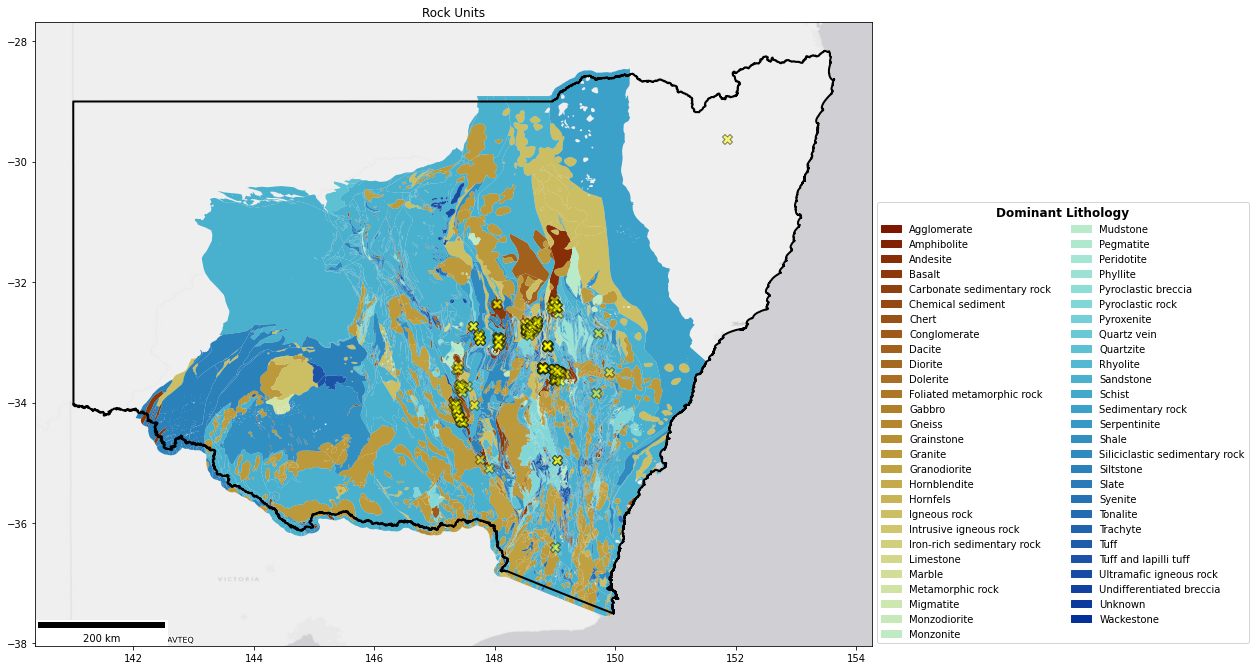

In [10]:
rock_units_file = './Datasets/Geology/Polygons/RockUnits_LAO.shp'
rock_units = gpd.read_file(rock_units_file)

rock_units_ = sorted(rock_units['Dominant_L'].unique())

cmap = cmc.roma
palette = cmap(np.linspace(0, 1, len(rock_units_)))

unit_colors = {unit: palette[i] for i, unit in enumerate(rock_units_)}

fig, ax = plt.subplots(figsize=(15, 15))
for unit, color in unit_colors.items():
    subset = rock_units[rock_units['Dominant_L'] == unit]
    subset.plot(ax=ax, color=color)

nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

title_font = FontProperties(weight='bold', size=12)

plt.legend(handles=patches, bbox_to_anchor=(1, 0.72), loc='upper left', title='Dominant Lithology',
          title_fontproperties=title_font, ncol=2)

scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)
ax.add_artist(scalebar)

plt.title('Rock Units')
plt.show()

### Raster Data Layers

#### Magnetic Grids

In [11]:
magnetic_files = [
    './Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGrav-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGravTHD-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Phase-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PSusp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC1km2kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC2km4kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC4km8kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC12km16kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC16km20kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC24km30kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC36km42kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC42km50kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.tif'
    ]

@interact(file=magnetic_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS…

#### Gravity

In [12]:
gravity_files = [
    './Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_ir.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_scba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa-IncludesAirborne.tif'
    ]

@interact(file=gravity_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif…

#### Remote Sensing

In [13]:
remote_sensing_files = [
    './Datasets/Remote Sensing/AlOH_Group_Composition.tif',
    './Datasets/Remote Sensing/AlOH_Group_Content.tif',
    './Datasets/Remote Sensing/FeOH_Group_Content.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Composition.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Content.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Content_in_MgOH.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Index.tif',
#     './Datasets/Remote Sensing/Green_Vegetation.tif',
    './Datasets/Remote Sensing/Gypsum_Index.tif',
    './Datasets/Remote Sensing/Kaolin_Group_Index.tif',
    './Datasets/Remote Sensing/MgOH_Group_Composition.tif',
    './Datasets/Remote Sensing/MgOH_Group_Content.tif',
    './Datasets/Remote Sensing/Opaque_Index.tif',
    './Datasets/Remote Sensing/Quartz_Index.tif',
    './Datasets/Remote Sensing/Silica_Index.tif'
    ]

@interact(file=remote_sensing_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Remote Sensing/AlOH_Group_Composition.…

#### Elevation

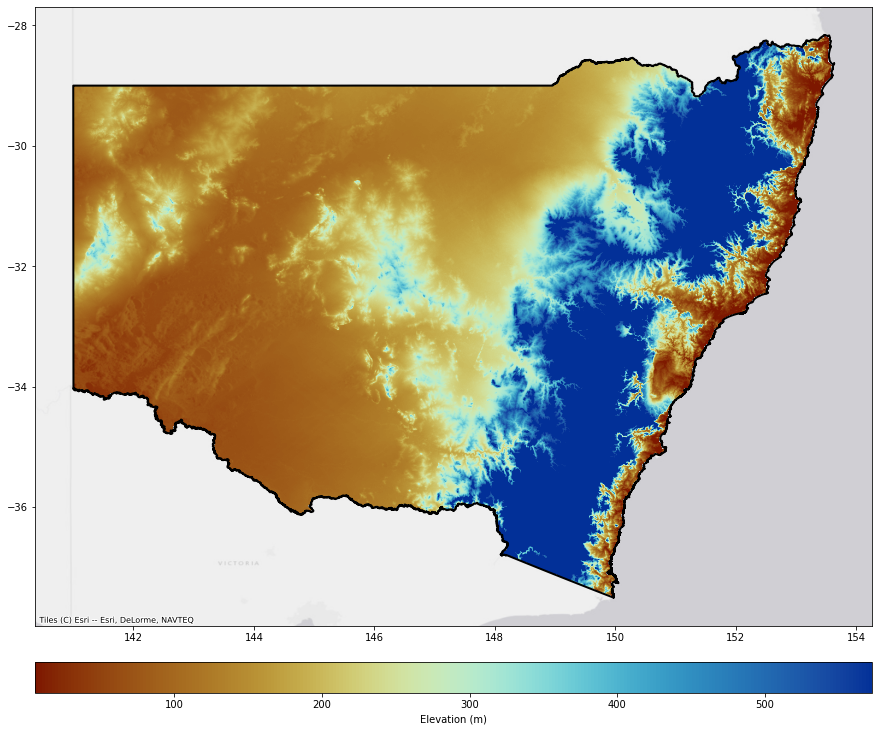

In [14]:
elevation_file = './Datasets/Elevation/Gravmap2019-grid-dem_geoid.tif'

raster = rxr.open_rasterio(elevation_file, masked=True).squeeze()

raster_array = raster.values
v_mean = np.nanmean(raster_array)
v_std = np.nanstd(raster_array)

fig, ax = plt.subplots(figsize=(15, 15))
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Elevation (m)', cax=cax)
plt.show()

### Extract the Coordinates of Mineral Occurrences

In [15]:
# export the coordinates to a CSV file
deposit_coords_file = './Datasets/Outputs/training_data_deposit_coords.csv'

if os.path.isfile(deposit_coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(deposit_coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_x = min_occ.geometry.x
    deposit_y = min_occ.geometry.y
    deposit_num = min_occ.shape[0]
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    
    size_code = pd.Series.tolist(min_occ['SIZE_CODE'])
    sample_weight = []
    for i in range(len(size_code)):
        if size_code[i] == 'VLG':
            sample_weight.append(0.5)
        elif size_code[i] == 'LGE':
            sample_weight.append(0.4)
        elif size_code[i] == 'MED':
            sample_weight.append(0.3)
        elif size_code[i] == 'SML':
            sample_weight.append(0.2)
        elif size_code[i] == 'OCC':
            sample_weight.append(0.1)
        
    deposit_coords['label'] = 1
    deposit_coords['sample_weight'] = sample_weight
    deposit_coords.to_csv(deposit_coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {deposit_coords_file}.')

The coordinates of deposits already exist.


### Prepare the Training Data File

#### Vector Data Layers

##### Polylines

In [16]:
line_files = intrusion_bndy_files + metamorphic_bndy_files + bndy_files
line_files.append(metamorphic_iso_file)
line_files.append(vs_cluster_file)

deposit_lines_file = f'./Datasets/Outputs/training_data_deposit_lines.csv'

if os.path.isfile(deposit_lines_file):
    print('The lines dataset (deposits) already exists.')
    deposit_lines_data = pd.read_csv(deposit_lines_file, index_col=False)
else:
    deposit_lines_data = get_dist_line(deposit_x, deposit_y, line_files, distance_type='geodesic')
    deposit_lines_data.to_csv(deposit_lines_file, index=False)
    print(f'The lines dataset (deposits) has been saved to {deposit_lines_file}.')

The lines dataset (deposits) already exists.


##### Polygons

In [17]:
deposit_cat_file = f'./Datasets/Outputs/training_data_deposit_categorical.csv'

if os.path.isfile(deposit_cat_file):
    print('The categorical dataset (deposits) already exists.')
    deposit_cat_data = pd.read_csv(deposit_cat_file, index_col=False)
else:
    deposit_meta_fac = get_cat_data(deposit_x, deposit_y, meta_fac_files, field='MetFacies')
    deposit_intrusions = get_cat_data(deposit_x, deposit_y, intrusions_file, field='Dominant_L')
    deposit_rock_units = get_cat_data(deposit_x, deposit_y, rock_units_file, field='Dominant_L')
    deposit_cat_data = pd.concat([deposit_meta_fac, deposit_intrusions, deposit_rock_units], axis=1)
    deposit_cat_data.to_csv(deposit_cat_file, index=False)
    print(f'The categorical dataset (deposits) has been saved to {deposit_cat_file}.')

The categorical dataset (deposits) already exists.


#### Grids

In [18]:
# grid_files = magnetic_files + gravity_files + radiometric_files + remote_sensing_files
grid_files = magnetic_files

deposit_grid_file = './Datasets/Outputs/training_data_deposit_grids.csv'

if os.path.isfile(deposit_grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(deposit_grid_file, index_col=False)
else:
    deposit_grid_stat_data = get_grid_stat_features(deposit_x, deposit_y, grid_files, buffer_shape='square', buffer_size=10)
    deposit_grid_tex_data = get_grid_tex_features(deposit_x, deposit_y, grid_files, buffer_size=10)
    deposit_elev_stat_data = get_grid_grad_stat_features(deposit_x, deposit_y, elevation_file, buffer_shape='square', buffer_size=10)
    deposit_grid_data = pd.concat([deposit_grid_stat_data, deposit_grid_tex_data, deposit_elev_stat_data], axis=1)
    deposit_grid_data.to_csv(deposit_grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {deposit_grid_file}.')

The grid dataset (deposits) already exists.


#### Create the Training Data File of Mineral Occurrences

In [19]:
# concatenate all the features generated using the coordinates of the mineral occurrences (positive samples)
deposit_training_data_file = f'./Datasets/Outputs/training_data_deposit.csv'

if os.path.isfile(deposit_training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(deposit_training_data_file, index_col=False)    
    deposit_training_data_columns = deposit_training_data.columns.tolist()
    deposit_num_data_columns = []
    deposit_cat_data_columns = []

    for column in deposit_training_data_columns:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            deposit_cat_data_columns.append(column)
        else:
            deposit_num_data_columns.append(column)
    
    deposit_num_data_columns = [e for e in deposit_num_data_columns if e not in ('label', 'sample_weight')]
    deposit_num_data = deposit_training_data[deposit_num_data_columns]
    deposit_cat_data = deposit_training_data[deposit_cat_data_columns]
else:
    deposit_training_data = pd.concat([
        deposit_coords,
        deposit_grid_data,
        deposit_lines_data,
        deposit_cat_data],
        axis=1,
        join='outer')
    
    # remove the samples with missing values
    deposit_training_data = deposit_training_data.dropna()

    # separate numerical and categorical features
    deposit_num_data = deposit_training_data[deposit_training_data.columns[4:deposit_training_data.shape[1]-deposit_cat_data.shape[1]]]
    deposit_cat_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_cat_data.shape[1]:deposit_training_data.shape[1]]]
    
    deposit_cat_data_columns = deposit_cat_data.columns.to_list()
    deposit_features = pd.concat([deposit_num_data, deposit_cat_data], axis=1).reset_index(drop=True)
    deposit_labels = deposit_training_data[deposit_training_data.columns[2]].reset_index(drop=True)
    deposit_weights = deposit_training_data[deposit_training_data.columns[3]].reset_index(drop=True)
    deposit_training_data = pd.concat([deposit_labels, deposit_weights, deposit_features], axis=1).reset_index(drop=True)
    deposit_training_data.to_csv(deposit_training_data_file, index=False)
    
    print(f'The training data file (deposits) has been saved to {deposit_training_data_file}.')

The training data file (deposits) already exists.


### Random (Unlabelled) Samples

The coordinates of unlabelled samples already exist.


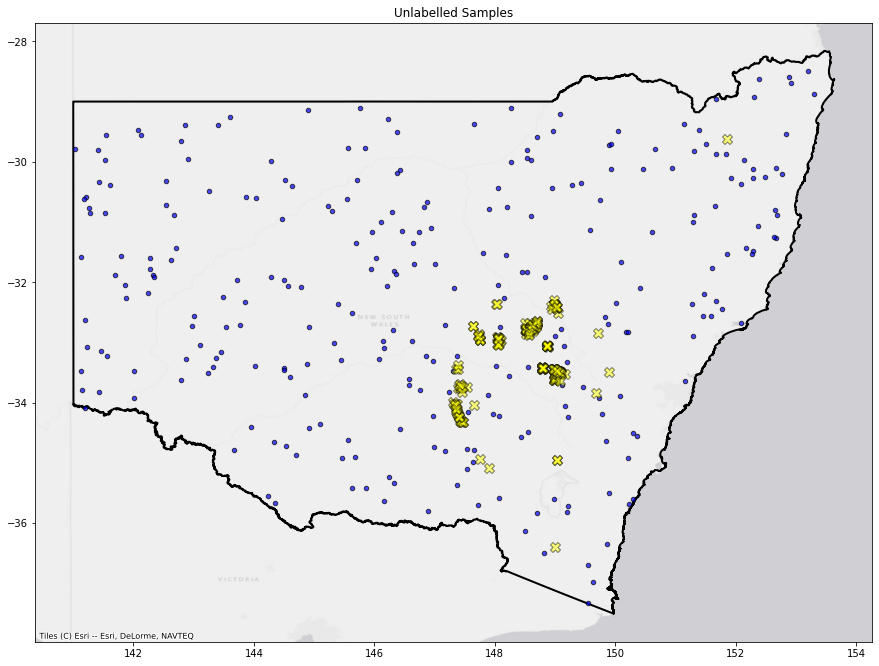

In [20]:
# generate and extract the coordinates of a number of random samples within the desired polygon
def get_unlab_samples(polygon, num_features):
    bounds = polygon.bounds
    
    rand_x = np.random.uniform(low=extent[0], high=extent[1], size=deposit_training_data.shape[0]*2)
    rand_y = np.random.uniform(low=extent[2], high=extent[3], size=deposit_training_data.shape[0]*2)
    
    unlab_x = []
    unlab_y = []

    for x, y in zip(rand_x, rand_y):
        if len(unlab_x) == deposit_training_data.shape[0]:
            break
        p = Point((x, y))
        if p.within(polygon.geometry[0]):
            unlab_x.append(x)
            unlab_y.append(y)
    
    return unlab_x, unlab_y

num_features = deposit_training_data.shape[1] - 1
# export the coordinates of the random samples to a CSV file
unlab_coords_file = './Datasets/Outputs/training_data_unlab_coords.csv'

if os.path.isfile(unlab_coords_file):
    print('The coordinates of unlabelled samples already exist.')
    unlab_coords = pd.read_csv(unlab_coords_file, index_col=False)
    unlab_x = pd.Series.tolist(unlab_coords['X'])
    unlab_y = pd.Series.tolist(unlab_coords['Y'])
else:
    unlab_x, unlab_y = get_unlab_samples(nsw_bndy, num_features)
    unlab_coords = pd.DataFrame(unlab_x, columns=['X'])
    unlab_coords['Y'] = unlab_y
    unlab_label = [0]*len(unlab_x)
    unlab_coords['label'] = unlab_label
    unlab_coords['sample_weight'] = 0.5
    unlab_coords.to_csv(unlab_coords_file, index=False)
    print(f'The coordinates of unlabelled samples have been saved to {unlab_coords_file}.')

# plot unlabelled samples
fig, ax = plt.subplots(figsize=(15, 15))
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
ax.scatter(unlab_x, unlab_y, color='blue', edgecolors='black', s=20, alpha=0.7)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Unlabelled Samples')
plt.show()

#### Create the Training Data File of Random Samples

In [21]:
unlab_lines_file = './Datasets/Outputs/training_data_unlab_lines.csv'

if os.path.isfile(unlab_lines_file):
    print('The lines dataset (unlabelled samples) already exists.')
    unlab_lines_data = pd.read_csv(unlab_lines_file, index_col=False)
else:
    unlab_lines_data = get_dist_line(unlab_x, unlab_y, line_files, distance_type='geodesic')
    unlab_lines_data = unlab_lines_data[unlab_lines_data.columns.intersection(deposit_lines_data.columns)]
    unlab_lines_data.to_csv(unlab_lines_file, index=False)
    print(f'The lines dataset (unlabelled samples) has been saved to {unlab_lines_file}.')

unlab_cat_file = './Datasets/Outputs/training_data_unlab_categorical.csv'

if os.path.isfile(unlab_cat_file):
    print('The categorical dataset (unlabelled samples) already exists.')
    unlab_cat_data = pd.read_csv(unlab_cat_file, index_col=False)
else:
    unlab_meta_fac = get_cat_data(unlab_x, unlab_y, meta_fac_files, field='MetFacies')
    unlab_intrusions = get_cat_data(unlab_x, unlab_y, intrusions_file, field='Dominant_L')
    unlab_rock_units = get_cat_data(unlab_x, unlab_y, rock_units_file, field='Dominant_L')
    unlab_cat_data = pd.concat([unlab_meta_fac, unlab_intrusions, unlab_rock_units], axis=1)
    unlab_cat_data = unlab_cat_data[unlab_cat_data.columns.intersection(deposit_cat_data.columns)]
    unlab_cat_data.to_csv(unlab_cat_file, index=False)
    print(f'The categorical dataset (unlabelled samples) has been saved to {unlab_cat_file}.')

unlab_grid_file = './Datasets/Outputs/training_data_unlab_grids.csv'

if os.path.isfile(unlab_grid_file):
    print('The grid dataset (unlabelled samples) already exists.')
    unlab_grid_data = pd.read_csv(unlab_grid_file, index_col=False)
else:
    unlab_grid_stat_data = get_grid_stat_features(unlab_x, unlab_y, grid_files, buffer_shape='square', buffer_size=10)
    unlab_grid_tex_data = get_grid_tex_features(unlab_x, unlab_y, grid_files, buffer_size=10)
    unlab_elev_stat_data = get_grid_grad_stat_features(unlab_x, unlab_y, elevation_file, buffer_shape='square', buffer_size=10)
    unlab_grid_data = pd.concat([unlab_grid_stat_data, unlab_grid_tex_data, unlab_elev_stat_data], axis=1)
    unlab_grid_data = unlab_grid_data[unlab_grid_data.columns.intersection(deposit_grid_data.columns)]
    unlab_grid_data.to_csv(unlab_grid_file, index=False)
    print(f'The grid dataset (unlabelled samples) has been saved to {unlab_grid_file}.')

The lines dataset (unlabelled samples) already exists.
The categorical dataset (unlabelled samples) already exists.
The grid dataset (unlabelled samples) already exists.


In [22]:
# concatenate all the features generated in the previous cell
unlab_training_data_file = './Datasets/Outputs/training_data_unlab.csv'

if os.path.isfile(unlab_training_data_file):
    print('The training data file (unlabelled samples) already exists.')
    unlab_training_data = pd.read_csv(unlab_training_data_file, index_col=False)
else:
    unlab_training_data = pd.concat([
        unlab_coords,
        unlab_grid_data,
        unlab_lines_data,
        unlab_cat_data],
        axis=1,
        join='outer'
    )
    
    # remove missing values
    unlab_training_data = unlab_training_data.dropna()
    unlab_training_data = unlab_training_data[unlab_training_data.columns.intersection(deposit_training_data.columns)]
    unlab_training_data.to_csv(unlab_training_data_file, index=False)
    
    print(f'The training data file (unlabelled samples) has been saved to {unlab_training_data_file}.')

Xy_train_original_df_file = './Datasets/Outputs/Xy_train_original.csv'

if os.path.isfile(Xy_train_original_df_file):
    Xy_train_original_df = pd.read_csv(Xy_train_original_df_file, index_col=False)
    print('Features file already exists!')
    
    with open('./Datasets/Outputs/st_scaler.pkl', 'rb') as f:
        st_scaler = pickle.load(f)
        
    with open('./Datasets/Outputs/encoder.pkl', 'rb') as f:
        enc = pickle.load(f)
else:
    deposit_labels = deposit_training_data['label']
    unlab_labels = unlab_training_data['label']
    
    deposit_weights = deposit_training_data['sample_weight']
    unlab_weights = unlab_training_data['sample_weight']
    
    labels = pd.concat([deposit_labels, unlab_labels]).reset_index(drop=True)
    weights = pd.concat([deposit_weights, unlab_weights]).reset_index(drop=True)
    
    training_data_original = pd.concat([deposit_training_data, unlab_training_data]).reset_index(drop=True)
    
    # separate numerical and categorical features
    training_data_num = training_data_original[deposit_num_data.columns]
    training_data_cat = training_data_original[deposit_cat_data.columns]

    # drop highly correlated features
    # create a correlation matrix
    corr_matrix = training_data_num.corr(method='spearman').abs()
    corr_matrix.to_csv('./Datasets/Outputs/corr.csv', index=True)
    # select the upper triangle of the correlation matrix
    corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # find features with the correlation greater than 0.7
    corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
    # print('List of the features removed due to high correlation with other features:', corr_drop)
    # drop features
    training_data_num_purged = training_data_num.drop(corr_drop, axis=1)
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(training_data_cat)
    training_data_cat_encoded = enc.transform(training_data_cat).toarray()
    training_data_cat_columns = enc.get_feature_names(training_data_cat.columns).tolist()
    training_data_cat_encoded = pd.DataFrame(training_data_cat_encoded, columns=training_data_cat_columns)
    
    features_labels_encoded = pd.concat([training_data_num_purged, training_data_cat_encoded, weights, labels], axis=1).reset_index(drop=True)
    features_labels_list = features_labels_encoded.columns.tolist()
    features_list = features_labels_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]

    deposit_data = features_labels_encoded[features_labels_encoded['label']==1]
    unlab_data = features_labels_encoded[features_labels_encoded['label']==0]

    deposit_features = deposit_data[deposit_data.columns[:-1]]
    unlab_features = unlab_data[unlab_data.columns[:-1]]

    deposit_labels = deposit_data[deposit_data.columns[-1]]
    unlab_labels = unlab_data[unlab_data.columns[-1]]

#     deposit_weights = deposit_data[deposit_data.columns[-2]]
#     unlab_weights = unlab_data[unlab_data.columns[-2]]
    
#     deposit_labels_weights = np.vstack((deposit_labels, deposit_weights))
    
    # train test
    # split positive samples into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(deposit_features, deposit_labels, train_size=0.75, random_state=42)
    X_train = np.vstack((X_train, unlab_features))
    y_train = np.vstack((y_train.values.reshape(-1, 1), unlab_labels.values.reshape(-1, 1)))
    
    Xy_train_original = np.hstack((X_train, y_train))
    Xy_train_original_df = pd.DataFrame(Xy_train_original, columns=features_labels_list)
    Xy_train_original_df.to_csv('./Datasets/Outputs/Xy_train_original.csv', index=False)
    
    X_test_df = pd.DataFrame(X_test, columns=features_list).reset_index(drop=True)
    y_test_df = pd.DataFrame(y_test, columns=['label']).reset_index(drop=True)
    weights_df = pd.DataFrame(X_test, columns=['sample_weight']).reset_index(drop=True)
    
    X_train_num = Xy_train_original_df[training_data_num_purged.columns]
    
    st_scaler = StandardScaler()
    X_train_num = st_scaler.fit_transform(X_train_num)
    X_train_num = pd.DataFrame(X_train_num, columns=training_data_num_purged.columns)
    
    X_test_num = X_test_df[training_data_num_purged.columns]
    X_test_num = st_scaler.transform(X_test_num)
    X_test_num = pd.DataFrame(X_test_num, columns=training_data_num_purged.columns)
    
    Xy_train = pd.concat([X_train_num, Xy_train_original_df[training_data_cat_columns], Xy_train_original_df['sample_weight'], Xy_train_original_df['label']], axis=1).reset_index(drop=True)
    Xy_test = pd.concat([X_test_num, X_test_df[training_data_cat_columns], weights_df, y_test_df], axis=1).reset_index(drop=True)
    
    Xy_train.to_csv('./Datasets/Outputs/Xy_train.csv', index=False)
    Xy_test.to_csv('./Datasets/Outputs/Xy_test.csv', index=False)
    
    # save the standard scaler model
    with open('./Datasets/Outputs/st_scaler.pkl', 'wb') as f:
        pickle.dump(st_scaler, f)
        
    # save the encoder model
    with open('./Datasets/Outputs/encoder.pkl', 'wb') as f:
        pickle.dump(enc, f)

The training data file (unlabelled samples) already exists.
Features file already exists!


In [23]:
def analyze_correlations(file_path, threshold=0.7):
    # Read the correlation matrix
    corr_matrix = pd.read_csv(file_path, index_col=0)
    
    # Dictionary to store correlations
    correlations = {}
    
    for column in corr_matrix.columns:
        positive_corr = []
        negative_corr = []
        feature = corr_matrix[column]
        
        for i in range(feature.shape[0]):
            if abs(feature[i]) >= threshold and feature.index[i] != column:
                if feature[i] > 0:
                    positive_corr.append((feature.index[i], feature[i]))
                else:
                    negative_corr.append((feature.index[i], feature[i]))
        
        if positive_corr or negative_corr:
            correlations[column] = {
                'positive': sorted(positive_corr, key=lambda x: x[1], reverse=True),
                'negative': sorted(negative_corr, key=lambda x: x[1])
            }
    
    return correlations

def generate_report(correlations, threshold):
    print(f"Correlation Analysis Report (Threshold: {threshold})")
    print("=" * 50)
    
    for feature, corr in correlations.items():
        print(f"\nFeature: {feature}")
        print("-" * 30)
        
        if corr['positive']:
            print("Positive Correlations:")
            for c, value in corr['positive']:
                print(f"  {c}: {value:.3f}")
        
        if corr['negative']:
            print("Negative Correlations:")
            for c, value in corr['negative']:
                print(f"  {c}: {value:.3f}")
    
    print("\nTotal features with strong correlations:", len(correlations))

# Main execution
file_path = './Datasets/Outputs/corr.csv'
threshold = 0.7

correlations = analyze_correlations(file_path, threshold)
generate_report(correlations, threshold)

Correlation Analysis Report (Threshold: 0.7)

Feature: Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean
------------------------------
Positive Correlations:
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_mean: 0.944
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_mean: 0.872
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_mean: 0.833
  Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019_mean: 0.749
  Magmap2019-grid-tmi_rtp_upcon-UC1km2kmRes-AWAGS_MAG_2019_mean: 0.706

Feature: Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_std
------------------------------
Positive Correlations:
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_std: 0.985
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_std: 0.980
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_std: 0.966
  Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019_std: 0.962
  Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019_mean: 0.961
  Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019_std: 0.960
  Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_min: 0.956


  Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_min: 0.795
  Magmap2019-grid-tmi_rtp_enhancement-PSusp-AWAGS_MAG_2019_max: 0.794
  Magmap2019-grid-tmi_rtp_upcon-UC1km2kmRes-AWAGS_MAG_2019_max: 0.793
  Magmap2019-grid-tmi_rtp_upcon-UC4km8kmRes-AWAGS_MAG_2019_std: 0.792
  Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019_max: 0.789
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_max: 0.784
  Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019_min: 0.783
  Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019_max: 0.781
  Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019_max: 0.780
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_min: 0.779
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_median: 0.775
  Magmap2019-grid-tmi-AWAGS_MAG_2019_max: 0.774
  Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_max: 0.770
  Magmap2019-grid-tmi-AWAGS_MAG_2019_min: 0.767
  Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019_min: 0.760
  Magmap2019-grid-tmi_rtp_upcon-UC2km4kmRes-AWAGS_MAG_2019_max: 0.759
  Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_201

  Magmap2019-grid-tmi_rtp_enhancement-PSusp-AWAGS_MAG_2019_mean: 0.734
  Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_2019_mean: 0.731
  Magmap2019-grid-tmi_rtp_upcon-UC12km16kmRes-AWAGS_MAG_2019_mean: 0.728
  Magmap2019-grid-tmi_rtp_upcon-UC12km16kmRes-AWAGS_MAG_2019_median: 0.724
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_max: 0.721
  Magmap2019-grid-tmi_rtp_upcon-UC4km8kmRes-AWAGS_MAG_2019_mean: 0.720
  Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_2019_median: 0.720
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_min: 0.718
  Magmap2019-grid-tmi_rtp_upcon-UC16km20kmRes-AWAGS_MAG_2019_mean: 0.717
  Magmap2019-grid-tmi_rtp_upcon-UC16km20kmRes-AWAGS_MAG_2019_median: 0.711
  Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019_mean: 0.708
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_median: 0.705
  Magmap2019-grid-tmi_rtp_upcon-UC36km42kmRes-AWAGS_MAG_2019_std: 0.702

Feature: Magmap2019-grid-tmi-AWAGS_MAG_2019_min
--------------------------

### Create the Predictive Model

#### Hyperparameter Tuning

In [24]:
# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

if os.path.isfile('./Datasets/Outputs/model.pkl'):
    print('The model already exists!')
    # load the model
    with open('./Datasets/Outputs/model.pkl', 'rb') as f:
        bc_best = pickle.load(f)
else:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    bc = BaggingPuClassifier(rf, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train_, X_test_, y_train_, y_test_ = train_test_split(features, labels, train_size=0.75, random_state=42)

    sample_weight_train = X_train_[X_train_.columns[-1]]
    X_train_ = X_train_[X_train_.columns[:-1]]
    sample_weight_test = X_test_[X_test_.columns[-1]]
    X_test_ = X_test_[X_test_.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train_)-sum(y_train_))), int(0.9*(len(y_train_)-sum(y_train_))))
    }

    bc_bayes_search = BayesSearchCV(bc, search_space, n_iter=50, # specify how many iterations
                                    scoring='accuracy', n_jobs=-1, cv=n_fold, verbose=1, random_state=42, return_train_score=True)
    bc_bayes_search.fit(X_train_, y_train_, sample_weight=sample_weight_train) # callback=on_step will print score after each iteration

    X_pred = bc_bayes_search.best_estimator_.predict(X_test_)
    X_pred_acc = accuracy_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_pre = precision_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_rec = recall_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_f1 = f1_score(y_test_, X_pred, sample_weight=sample_weight_test)

    bc_best = bc_bayes_search.best_estimator_
    bc_best_acc = bc_bayes_search.best_score_
    print('The highest accuracy during cross validation:', bc_best_acc)
    print('Accuracy:', X_pred_acc)
    print('Precision:', X_pred_pre)
    print('Recall:', X_pred_rec)
    print('F1-Score:', X_pred_f1)
    
    # save the model
    with open('./Datasets/Outputs/model.pkl', 'wb') as f:
        pickle.dump(bc_best, f)
    
    importances = []
    estimators = bc_best.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

The model already exists!


In [25]:
print(bc_best)

BaggingPuClassifier(base_estimator=RandomForestClassifier(max_depth=20,
                                                          max_features='sqrt',
                                                          min_samples_leaf=2,
                                                          min_samples_split=13,
                                                          n_estimators=200,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=146, n_jobs=-1, random_state=42)


In [26]:
labels_estimated = []
for pair in bc_best.oob_decision_function_:
    if np.isnan(pair[0]) or pair[0] < pair[1]:
        labels_estimated.append(1)
    else:
        labels_estimated.append(0)
        
print('Number of positive samples', labels_estimated.count(1))
print('Number of negative samples', labels_estimated.count(0))

Number of positive samples 163
Number of negative samples 200


In [27]:
Xy_test = pd.read_csv('./Datasets/Outputs/Xy_test.csv', index_col=False)
X_test = Xy_test[Xy_test.columns[:-2]]
y_test = Xy_test[Xy_test.columns[-1]]
sample_weight_test = Xy_test[Xy_test.columns[-2]]
X_pred = bc_best.predict(X_test)
X_pred_acc = accuracy_score(y_test, X_pred, sample_weight=sample_weight_test)
print('Accuracy:', X_pred_acc)

Accuracy: 0.9134615384615384


#### Feature Importance

In [28]:
features_importance_file = './Datasets/Outputs/features_importance.csv'

if os.path.isfile(features_importance_file):
    features_importance = pd.read_csv(features_importance_file, index_col=False).to_numpy().tolist()
else:
    output_features = Xy_train_original_df.columns.tolist()
    output_features = [e for e in output_features if e not in ('label', 'sample_weight')]
    
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_importance = [(feature, round(importance, 5)) for feature, importance in zip(output_features, importances_mean)]
    features_importance = sorted(features_importance, key=lambda x:x[1], reverse=True)
    features_importance_df = pd.DataFrame(features_importance, columns=['Feature', 'Importance'])
    features_importance_df['Variance'] = importances_var
    features_importance_df.to_csv(features_importance_file, index=False)

Text(0, 0.5, 'Cumulative Importance')

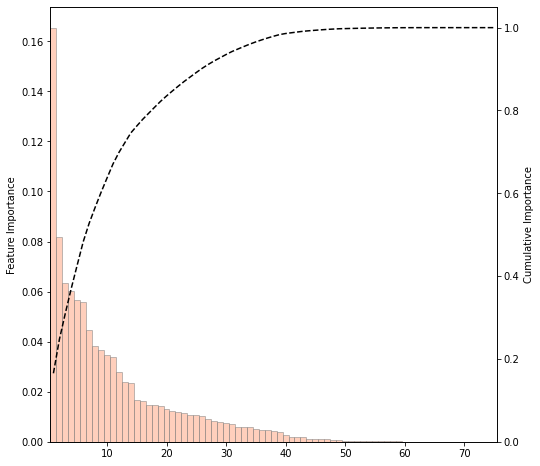

In [29]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

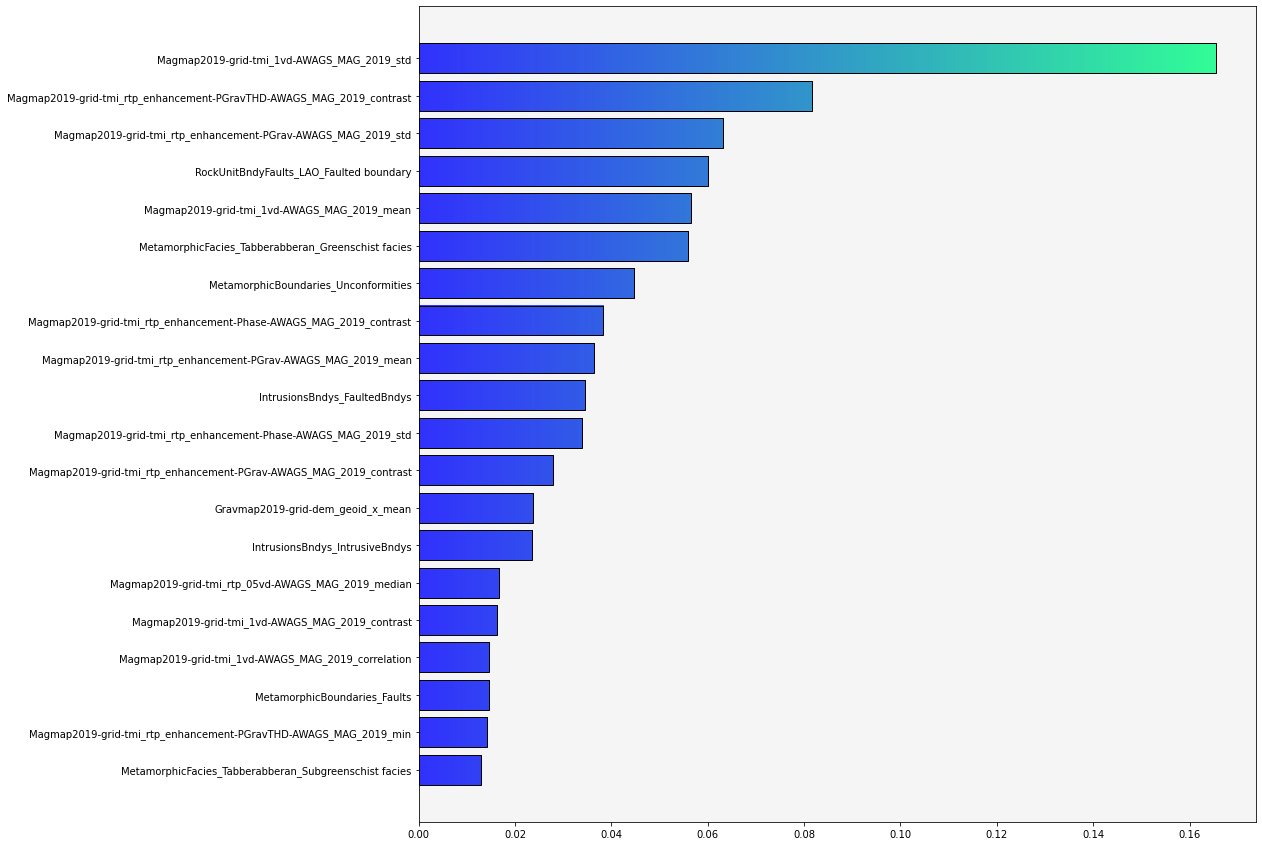

In [30]:
# print significant features above some threshold
features_importance_ = features_importance[:20]
features_importance_.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('winter')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

In [31]:
Xy_train_df = pd.read_csv('./Datasets/Outputs/Xy_train.csv', index_col=False)

@interact
def show_map(feature=Xy_train_df.columns):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.set_facecolor('whitesmoke')
    ax2 = ax1.twiny()
    
    ax1.hist(Xy_train_original_df[feature], bins=25, alpha=0.0)

    h1 = ax2.hist(Xy_train_df.loc[Xy_train_df['label']==0][feature], bins=25, color='LightSalmon', label='Negative')
    h2 = ax2.hist(Xy_train_df.loc[Xy_train_df['label']==1][feature], bins=25, color='DarkSeaGreen', label='Positive', alpha=0.8)

    ax2.legend()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

In [32]:
Xy_train_df_pivot = Xy_train_df.pivot(columns=['label'])
Xy_train_original_df_pivot = Xy_train_original_df.pivot(columns=['label'])

nb_groups1 = Xy_train_df['label'].nunique()
nb_groups2 = Xy_train_original_df['label'].nunique()

@interact
def show_map(feature=Xy_train_df.columns):
    bplot1 = [Xy_train_df_pivot[feature][var].dropna() for var in Xy_train_df_pivot[feature]]
    bplot2 = [Xy_train_original_df_pivot[feature][var].dropna() for var in Xy_train_original_df_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(8, 8))
    box_param1 = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='black', fillstyle=None),
                      medianprops=dict(color='black'), boxprops=dict(facecolor='tab:blue'))
    box_param2 = dict(whis=(5, 95), widths=0, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='none', fillstyle=None),
                      medianprops=dict(color='none'), whiskerprops=dict(color='none'),
                      boxprops=dict(facecolor='none', edgecolor='none'))

    ax1.boxplot(bplot1, positions=np.arange(nb_groups1), **box_param1)

    ax2 = ax1.twinx()
    ax2.boxplot(bplot2, positions=np.arange(nb_groups2), **box_param2)

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
    ax1.set_xticklabels(['Negative', 'Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)

    # format y ticks
    yticks_fmt = dict(axis='y', labelsize=labelsize)

    # format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', **label_fmt)

    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

### Generate Target Points

The coordinates of target points already exist.
Number of samples:  7699


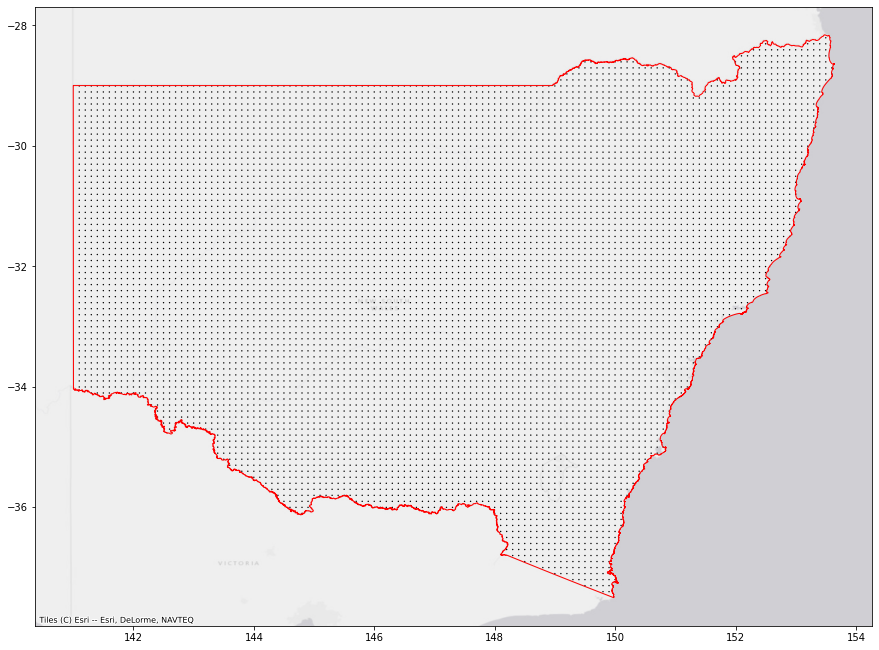

In [33]:
# set the sampling resolution
size_x = 0.1
size_y = 0.1

range_x = np.arange(extent_target[0], extent_target[1], size_x)
range_y = np.arange(extent_target[2], extent_target[3], size_y)

num_x = len(range_x)
num_y = len(range_y)

xs, ys = np.meshgrid(range_x, range_y)

target_coords_file = './Datasets/Outputs/target_coords.csv'
target_mask_file = './Datasets/Outputs/target_mask.csv'

# export the coordinates of the target points and create a mask to keep the points only inside the target polygon boundaries
if os.path.isfile(target_coords_file) and os.path.isfile(target_mask_file):
    print('The coordinates of target points already exist.')
    target_coords = pd.read_csv(target_coords_file, index_col=False)
    target_x = target_coords['X']
    target_y = target_coords['Y']
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    target_x = []
    target_y = []
    target_mask = []
    for xx, yy in zip(xs.flatten(), ys.flatten()):
        p = Point((xx, yy))
        if p.within(frame_target.geometry[0]):
            target_x.append(xx)
            target_y.append(yy)
            target_mask.append(True)
        else:
            target_mask.append(False)
    
    target_coords = pd.DataFrame(target_x, columns=['X'])
    target_coords['Y'] = target_y
    target_coords.to_csv(target_coords_file, index=False)
    
    mask_x = np.array([xs.flatten()]).T
    mask_y = np.array([ys.flatten()]).T
    target_mask_ = np.array([target_mask]).T
    target_mask = np.hstack((mask_x, mask_y, target_mask_))
    np.savetxt(target_mask_file, target_mask, delimiter=',')
    print('The coordinates of target points and mask have been saved.')

print(f'Number of samples: ', len(target_x))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(target_x, target_y, color='black', edgecolors='none', s=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
plt.show()

#### Extract Values of Features at Target Points

In [34]:
target_lines_file = './Datasets/Outputs/target_lines.csv'

if os.path.isfile(target_lines_file):
    print('The lines dataset (traget points) already exists.')
    target_lines_data = pd.read_csv(target_lines_file, index_col=False)
else:
    target_lines_data = get_dist_line(target_x, target_y, line_files, distance_type='geodesic')
    target_lines_data = target_lines_data[target_lines_data.columns.intersection(deposit_lines_data.columns)]
    target_lines_data.to_csv(target_lines_file, index=False)
    print(f'The lines dataset (target points) has been saved to {target_lines_file}.')

target_cat_file = './Datasets/Outputs/target_categorical.csv'

if os.path.isfile(target_cat_file):
    print('The categorical dataset (target points) already exists.')
    target_cat_data = pd.read_csv(target_cat_file, index_col=False)
else:
    target_meta_fac = get_cat_data(target_x, target_y, meta_fac_files, field='MetFacies')
    target_intrusions = get_cat_data(target_x, target_y, intrusions_file, field='Dominant_L')
    target_rock_units = get_cat_data(target_x, target_y, rock_units_file, field='Dominant_L')
    target_cat_data = pd.concat([target_meta_fac, target_intrusions, target_rock_units], axis=1)
    target_cat_data = target_cat_data[target_cat_data.columns.intersection(deposit_cat_data.columns)]
    target_cat_data.to_csv(target_cat_file, index=False)
    print(f'The categorical dataset (target points) has been saved to {target_cat_file}.')

target_grid_file = './Datasets/Outputs/target_grids.csv'

if os.path.isfile(target_grid_file):
    print('The grid dataset (target points) already exists.')
    target_grid_data = pd.read_csv(target_grid_file, index_col=False)
else:
    target_grid_stat_data = get_grid_stat_features(target_x, target_y, grid_files, buffer_shape='square', buffer_size=10)
    target_grid_tex_data = get_grid_tex_features(target_x, target_y, grid_files, buffer_size=10)
    target_elev_stat_data = get_grid_grad_stat_features(target_x, target_y, elevation_file, buffer_shape='square', buffer_size=10)
    target_grid_data = pd.concat([target_grid_stat_data, target_grid_tex_data, target_elev_stat_data], axis=1)
    target_grid_data = target_grid_data[target_grid_data.columns.intersection(deposit_grid_data.columns)]
    target_grid_data.to_csv(target_grid_file, index=False)
    print(f'The grid dataset (target points) has been saved to {target_grid_file}.')

The lines dataset (traget points) already exists.
The categorical dataset (target points) already exists.
The grid dataset (target points) already exists.


In [ ]:
# concatenate all the features generated in the previous cell
target_data_file = './Datasets/Outputs/target_data.csv'

if os.path.isfile(target_data_file):
    print('The target data file already exists.')
    target_data = pd.read_csv(target_data_file, index_col=False)
else:
    target_data = pd.concat([target_coords,
                             target_grid_data,
                             target_lines_data,
                             target_cat_data],
                            axis=1,
                            join='outer')
    target_data.to_csv(target_data_file, index=False)
    print(f'The target data file has been saved to {target_data_file}.')

target_features_file = './Datasets/Outputs/target_features.csv'

if os.path.isfile(target_features_file):
    print('The target features file already exists.')
    target_features = pd.read_csv(target_features_file, index_col=False)
    target_coords_purged = pd.read_csv('./Datasets/Outputs/target_coords_purged.csv', index_col=False)
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    index_null = target_data[target_data.isnull().any(axis=1)].index.to_list()

    for index in index_null:
        for i in range(target_mask.shape[0]):
            if target_data['X'][index] == target_mask[i, 0] and target_data['Y'][index] == target_mask[i, 1]:
                target_mask[i, 2] = False
                
    np.savetxt(target_mask_file, target_mask, delimiter=',')

    # remove missing values
    target_data = target_data.dropna()
    target_coords_purged = target_data[['X', 'Y']]
    target_coords_purged.to_csv('./Datasets/Outputs/target_coords_purged.csv', index=False)

    features_label_list = Xy_train_original_df.columns.tolist()
    features_list = features_label_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]
    num_features_list = []
    cat_features_list = []

    for column in features_list:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            cat_features_list.append(column)
        else:
            num_features_list.append(column)
    
    # separate numerical and categorical features
    target_data_num = target_data[num_features_list]
    target_data_cat = target_data[deposit_cat_data_columns]

    st_scaler.fit(target_data_num)
    target_features_num = st_scaler.transform(target_data_num)
    target_features_cat = enc.transform(target_data_cat).toarray()
    target_features = np.hstack((target_features_num, target_features_cat))
    target_features = pd.DataFrame(target_features, columns=features_list)
    target_features.to_csv(target_features_file, index=False)
    print(f'The target features file has been saved to {target_data_file}.')

The target data file already exists.


In [ ]:
min_occ_clipped = min_occ.clip(frame_target)

@interact(feature=target_features.columns.tolist())
def show_map(feature):
    feature_values = []
    count = 0

    for mask in target_mask[:, 2]:
        if mask:
            feature_values.append(target_features.iloc[count][feature])
            count += 1
        else:
            feature_values.append(np.nan)

    feature_values_2d = np.reshape(feature_values, (num_y, num_x))
    fig, ax = plt.subplots(figsize=(15, 15))
    min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

    cb = plt.imshow(feature_values_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=feature, cax=cax)
    ax.set_title(feature)
    plt.show()

### Calculate Probabilities

In [ ]:
target_probs_file = './Datasets/Outputs/target_probs.csv'

if os.path.isfile(target_probs_file):
    print('The probability file already exists.')
    target_probs = pd.read_csv(target_probs_file, index_col=False)
else:
    probs = bc_best.predict_proba(target_features)
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs = target_coords_purged.reset_index().copy()
    target_probs['prob'] = probs_scaled
    target_probs.to_csv(target_probs_file, index=False)
    print(f'The probability file has been saved to {target_probs_file}.')

#### Plot Prospectivity Map

In [ ]:
# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs['X'], target_probs['Y'], 30, c=target_probs['prob'], cmap='Spectral_r')
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)

frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

In [ ]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

plt.imshow(probs_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [ ]:
probs_2d_ud = np.flipud(probs_2d)

# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
geotransform = (xmin, 0.1, 0, ymax, 0, -0.1)
map_file = './Datasets/Outputs/probability_map.tif'
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, num_x, num_y, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4283)
dataset.SetProjection(srs.ExportToWkt())
dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
dataset.FlushCache()
dataset = None

#### P-A Plot

In [ ]:
# Load the geotiff file (mineral prospectivity map) using rioxarray
prospectivity_data = rxr.open_rasterio('./Datasets/Outputs/probability_map.tif', masked=True).squeeze()

# Load the shapefile (mineral occurrences)
mineral_occurrences = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry.shp')

# Extract probability values at known mineral occurrence locations
occurrence_probabilities = []
for geom in mineral_occurrences.geometry:
    x, y = geom.x, geom.y
    # Extract probability value at this point
    prob_value = prospectivity_data.sel(x=x, y=y, method='nearest').item()
    occurrence_probabilities.append(prob_value)

# Convert to numpy array for easier manipulation
occurrence_probabilities = np.array(occurrence_probabilities)
occurrence_probabilities = occurrence_probabilities[~np.isnan(occurrence_probabilities)]

# Calculate total study area and the number of cells
total_area = np.count_nonzero(~np.isnan(prospectivity_data))
total_occurrences = len(occurrence_probabilities)

# Define the probability thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store results
occurrence_percentages = []
area_percentages = []

# Calculate percentages for each threshold
for threshold in thresholds:
    occurrence_percentage = np.sum(occurrence_probabilities >= threshold) / total_occurrences * 100
    area_percentage = np.sum(prospectivity_data >= threshold) / total_area * 100
    occurrence_percentages.append(occurrence_percentage)
    area_percentages.append(area_percentage)

# Convert lists to numpy arrays for plotting
occurrence_percentages = np.array(occurrence_percentages)
area_percentages = np.array(area_percentages)

# Create the P-A plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the occurrence percentages
ax1.plot(thresholds, occurrence_percentages, 'b-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('Percentage of Known Mineral Occurrences', color='b')
ax1.set_ylim(0, 100)
ax1.set_xlim(0, 1)
ax1.grid(True)  # Add grid to the first y-axis

# Create a second y-axis to plot the area percentages
ax2 = ax1.twinx()
ax2.plot(thresholds, area_percentages, 'r-')
ax2.set_ylabel('Percentage of Study Area', color='r')
ax2.set_ylim(100, 0)  # Inverted y-axis

# Add horizontal and vertical lines
intersection_x = 0.72
intersection_y1 = 95
intersection_y2 = 5
h_line = ax1.hlines(y=intersection_y1, xmin=0, xmax=1, color='g', linestyles=':')
v_line = ax1.vlines(x=intersection_x, ymin=0, ymax=100, color='g', linestyles=':')

# Add annotations for the lines
# X-axis annotation
ax1.annotate(f'{intersection_x}', xy=(intersection_x, -0.06), xycoords='data',
             xytext=(0, -20), textcoords='offset points',
             ha='center', va='top', color='g',
             arrowprops=dict(arrowstyle='->', color='g'))

# Left Y-axis (Percentage of Known Mineral Occurrences) annotation
ax1.annotate(f'{intersection_y1}%', xy=(0, intersection_y1), xycoords='data',
             xytext=(-25, 0), textcoords='offset points',
             ha='right', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Right Y-axis (Percentage of Study Area) annotation
ax2.annotate(f'{intersection_y2}%', xy=(1, intersection_y2), xycoords='data',
             xytext=(25, 0), textcoords='offset points',
             ha='left', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Add a text box to explain the intersection point
ax1.annotate(f'At probability {intersection_x}:\n{intersection_y1}% of occurrences\n{intersection_y2}% of area',
             xy=(0.7, 0.9), xycoords='axes fraction',
             ha='center', va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

plt.title('Prediction-Area Plot')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Adjust the plot margins to make room for annotations
plt.subplots_adjust(left=0.15, right=0.85)

plt.show()

### Select Important Features

In [ ]:
features_important = []

for i in range(len(features_importance)):
    if features_importance[i][1] >= 0.01:
        features_important.append(features_importance[i][0])

Xy_train_important_file = './Datasets/Outputs/Xy_train_important.csv'
Xy_test_important_file = './Datasets/Outputs/Xy_test_important.csv'

if os.path.isfile(Xy_train_important_file) and os.path.isfile(Xy_test_important_file):
    print('The training data file already exists.')
    Xy_train_important = pd.read_csv(Xy_train_important_file, index_col=False)
    Xy_test_important = pd.read_csv(Xy_test_important_file, index_col=False)
else:
    features_important.append('sample_weight')
    features_important.append('label')
    # features_important.remove()

    Xy_train_file = './Datasets/Outputs/Xy_train.csv'
    Xy_test_file = './Datasets/Outputs/Xy_test.csv'

    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    Xy_test = pd.read_csv(Xy_test_file, index_col=False)

    Xy_train_important = Xy_train[features_important]
    Xy_test_important = Xy_test[features_important]

    Xy_train_important.to_csv('./Datasets/Outputs/Xy_train_important.csv', index=False)
    Xy_test_important.to_csv('./Datasets/Outputs/Xy_test_important.csv', index=False)

### Create the Predictive Model

#### Hyperparameter Tuning

In [ ]:
# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

model_important_file = './Datasets/Outputs/model_important.pkl'

if os.path.isfile(model_important_file):
    print('The model already exists!')
    # load the model
    with open(model_important_file, 'rb') as f:
        bc_best_important = pickle.load(f)
else:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    bc = BaggingPuClassifier(rf, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train_important.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train_, X_test_, y_train_, y_test_ = train_test_split(features, labels, train_size=0.75, random_state=42)
    
    sample_weight_train = X_train_[X_train_.columns[-1]]
    X_train_ = X_train_[X_train_.columns[:-1]]
    sample_weight_test = X_test_[X_test_.columns[-1]]
    X_test_ = X_test_[X_test_.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train_)-sum(y_train_))), int(0.9*(len(y_train_)-sum(y_train_))))
    }

    bc_bayes_search = BayesSearchCV(bc, search_space, n_iter=50, # specify how many iterations
                                    scoring='accuracy', n_jobs=-1, cv=n_fold, verbose=1, random_state=42, return_train_score=True)
    bc_bayes_search.fit(X_train_, y_train_, sample_weight=sample_weight_train) # callback=on_step will print score after each iteration

    X_pred = bc_bayes_search.best_estimator_.predict(X_test_)
    X_pred_acc = accuracy_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_pre = precision_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_rec = recall_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_f1 = f1_score(y_test_, X_pred, sample_weight=sample_weight_test)
    
    bc_best_important = bc_bayes_search.best_estimator_
    bc_best_important_acc = bc_bayes_search.best_score_
    
    print('The highest accuracy during cross validation:', bc_best_important_acc)
    print('Accuracy:', X_pred_acc)
    print('Precision:', X_pred_pre)
    print('Recall:', X_pred_rec)
    print('F1-Score:', X_pred_f1)

    # save the model
    with open(model_important_file, 'wb') as f:
        pickle.dump(bc_best_important, f)
    
    importances = []
    estimators = bc_best_important.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

In [ ]:
print(bc_best_important)

In [ ]:
labels_estimated = []
for pair in bc_best_important.oob_decision_function_:
    if np.isnan(pair[0]) or pair[0] < pair[1]:
        labels_estimated.append(1)
    else:
        labels_estimated.append(0)
        
print('Number of positive samples', labels_estimated.count(1))
print('Number of negative samples', labels_estimated.count(0))

In [ ]:
Xy_test_important = pd.read_csv('./Datasets/Outputs/Xy_test_important.csv', index_col=False)
X_test = Xy_test_important[Xy_test_important.columns[:-2]]
y_test = Xy_test_important[Xy_test_important.columns[-1]]
sample_weight_test = Xy_test[Xy_test.columns[-2]]
X_pred = bc_best_important.predict(X_test)
X_pred_acc = accuracy_score(y_test, X_pred, sample_weight=sample_weight_test)
print('Accuracy:', X_pred_acc)

#### Feature Importance

In [ ]:
features_importance_important_file = './Datasets/Outputs/features_importance_important.csv'

if os.path.isfile(features_importance_important_file):
    features_importance_important = pd.read_csv(features_importance_important_file, index_col=False).to_numpy().tolist()
else:
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
    features_importance_important = [(feature, round(importance, 5)) for feature, importance in zip(features_important, importances_mean)]
        
    features_importance_important = sorted(features_importance_important, key=lambda x:x[1], reverse=True)
    features_importance_important_df = pd.DataFrame(features_importance_important, columns=['Feature', 'Importance'])
    features_importance_important_df['Variance'] = importances_var
    features_importance_important_df.to_csv(features_importance_important_file, index=False)

In [ ]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance_important]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance_important)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

In [ ]:
# print significant features above some threshold
features_importance_ = features_importance_important[:20]
features_importance_.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('winter')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

### Calculate Probabilities

In [ ]:
target_probs_important_file = './Datasets/Outputs/target_probs_important.csv'

if os.path.isfile(target_probs_important_file):
    print('The probability file already exists.')
    target_probs_important = pd.read_csv(target_probs_important_file, index_col=False)
else:
    try:
        features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
        probs = bc_best_important.predict_proba(target_features[features_important])
    except:
        probs = bc_best_important.predict_proba(target_features[features_important])
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs_important = target_coords_purged.reset_index().copy()
    target_probs_important['prob'] = probs_scaled
    target_probs_important.to_csv(target_probs_important_file, index=False)
    print(f'The probability file has been saved to {target_probs_important_file}.')

#### Plot Prospectivity Map

In [ ]:
min_occ_clipped = min_occ.clip(frame_target)

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs_important['X'], target_probs_important['Y'], 30, c=target_probs_important['prob'], cmap='Spectral_r')
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)

frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

In [ ]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs_important['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

plt.imshow(probs_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [ ]:
probs_2d_ud = np.flipud(probs_2d)

# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
geotransform = (xmin, 0.1, 0, ymax, 0, -0.1)
map_file = './Datasets/Outputs/probability_map_important.tif'
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, num_x, num_y, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4283)
dataset.SetProjection(srs.ExportToWkt())
dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
dataset.FlushCache()
dataset = None

#### P-A Plot

In [ ]:
# Load the geotiff file (mineral prospectivity map) using rioxarray
prospectivity_data = rxr.open_rasterio('./Datasets/Outputs/probability_map_important.tif', masked=True).squeeze()

# Load the shapefile (mineral occurrences)
mineral_occurrences = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry.shp')

# Extract probability values at known mineral occurrence locations
occurrence_probabilities = []
for geom in mineral_occurrences.geometry:
    x, y = geom.x, geom.y
    # Extract probability value at this point
    prob_value = prospectivity_data.sel(x=x, y=y, method='nearest').item()
    occurrence_probabilities.append(prob_value)

# Convert to numpy array for easier manipulation
occurrence_probabilities = np.array(occurrence_probabilities)
occurrence_probabilities = occurrence_probabilities[~np.isnan(occurrence_probabilities)]

# Calculate total study area and the number of cells
total_area = np.count_nonzero(~np.isnan(prospectivity_data))
total_occurrences = len(occurrence_probabilities)

# Define the probability thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store results
occurrence_percentages = []
area_percentages = []

# Calculate percentages for each threshold
for threshold in thresholds:
    occurrence_percentage = np.sum(occurrence_probabilities >= threshold) / total_occurrences * 100
    area_percentage = np.sum(prospectivity_data >= threshold) / total_area * 100
    occurrence_percentages.append(occurrence_percentage)
    area_percentages.append(area_percentage)

# Convert lists to numpy arrays for plotting
occurrence_percentages = np.array(occurrence_percentages)
area_percentages = np.array(area_percentages)

# Create the P-A plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the occurrence percentages
ax1.plot(thresholds, occurrence_percentages, 'b-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('Percentage of Known Mineral Occurrences', color='b')
ax1.set_ylim(0, 100)
ax1.set_xlim(0, 1)
ax1.grid(True)  # Add grid to the first y-axis

# Create a second y-axis to plot the area percentages
ax2 = ax1.twinx()
ax2.plot(thresholds, area_percentages, 'r-')
ax2.set_ylabel('Percentage of Study Area', color='r')
ax2.set_ylim(100, 0)  # Inverted y-axis

# Add horizontal and vertical lines
intersection_x = 0.78
intersection_y1 = 95
intersection_y2 = 5
h_line = ax1.hlines(y=intersection_y1, xmin=0, xmax=1, color='g', linestyles=':')
v_line = ax1.vlines(x=intersection_x, ymin=0, ymax=100, color='g', linestyles=':')

# Add annotations for the lines
# X-axis annotation
ax1.annotate(f'{intersection_x}', xy=(intersection_x, -0.06), xycoords='data',
             xytext=(0, -20), textcoords='offset points',
             ha='center', va='top', color='g',
             arrowprops=dict(arrowstyle='->', color='g'))

# Left Y-axis (Percentage of Known Mineral Occurrences) annotation
ax1.annotate(f'{intersection_y1}%', xy=(0, intersection_y1), xycoords='data',
             xytext=(-25, 0), textcoords='offset points',
             ha='right', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Right Y-axis (Percentage of Study Area) annotation
ax2.annotate(f'{intersection_y2}%', xy=(1, intersection_y2), xycoords='data',
             xytext=(25, 0), textcoords='offset points',
             ha='left', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Add a text box to explain the intersection point
ax1.annotate(f'At probability {intersection_x}:\n{intersection_y1}% of occurrences\n{intersection_y2}% of area',
             xy=(0.65, 0.9), xycoords='axes fraction',
             ha='center', va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

plt.title('Prediction-Area Plot')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Adjust the plot margins to make room for annotations
plt.subplots_adjust(left=0.15, right=0.85)

plt.show()